In [295]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED


In [296]:

np.random.seed(42) # for reproducibility
num_repetitions = 10000
num_xs = 500
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))
gauss_parameters = []


In [297]:
all_peaks = []

In [298]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [299]:
for i in range(num_repetitions):
    n_gauss = np.random.randint(5, 10)
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []

    min_d = 0.08
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:
            mean = np.random.uniform(1, 8)
            if all(abs(mean - m) >= min_d for m in used_means):
                used_means.append(mean)
                break
            attempts += 1
            if attempts > 80: # avoid inf loop
                break

        amp = np.random.uniform(0.5, 1.5)
        std_dev = np.random.uniform(0.05,0.2)

        gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
        signal += gauss
        parameters.append((amp, mean, std_dev))

        peak_index = np.argmax(gauss)
        peaks.append(peak_index)
        binary_peaks[i][peak_index] = 1

    signals[i] = signal
    gauss_parameters.append(parameters)
    all_peaks.append(peaks)

In [300]:
for i in range(num_repetitions):
    for idx in all_peaks[i]:
        binary_peaks[i][idx] = 1

In [301]:
binary_peaks[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [302]:
all_peaks[0]

[np.int64(382),
 np.int64(104),
 np.int64(352),
 np.int64(57),
 np.int64(124),
 np.int64(156),
 np.int64(152),
 np.int64(178)]

In [303]:
np.argmax(signals[0], axis=0)

np.int64(153)

In [304]:
peak_indices = []

In [305]:
ds = xr.Dataset(
    {
        "Gaussians": (["pattern", "x"], signals),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": x
    }
)

In [306]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values


In [307]:
%matplotlib inline

In [308]:
plt.close()

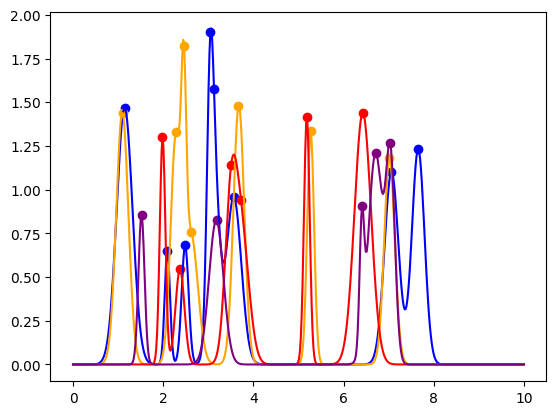

In [309]:
plt.figure()
colors = ['blue', 'orange', 'red', 'purple', 'green']
for i in range(4):
    plt.plot(x, signals[i], color=colors[i])
    plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]], color=colors[i])
plt.show()

In [310]:
gauss_parameters[3]

[(0.6987156815341724, 6.405713385076602, 0.050828317568540365),
 (1.2068573438476171, 6.708229999183839, 0.1593510752061481),
 (0.8584657285442726, 1.5183125621386324, 0.06738035892876947),
 (1.123298126827558, 7.041723981129155, 0.09963470372789739),
 (0.825183322026747, 3.1768762520096354, 0.15944092675070964)]